# 使用内置方法进行训练和评估

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# CancelledError: [Derived]RecvAsync is cancelled.

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 简介

本指南涵盖使用内置 API 进行训练和验证时需要的训练、评估和预测（推断）模型（例如 `model.fit()`、`model.evaluate()`、`model.predict()`）。

如果您有兴趣在指定自己的训练步骤函数时利用 `fit()`，请参阅<a data-md-type="link" href="https://tensorflow.google.cn/guide/keras/customizing_what_happens_in_fit/" class="">“自定义 `fit()` 中发生的操作”</a>指南。

如果您有兴趣从头开始编写自己的训练和评估循环，请参阅[“从头开始编写训练循环”](https://tensorflow.google.cn/guide/keras/writing_a_training_loop_from_scratch/)指南。

一般而言，无论您使用内置循环还是编写自己的循环，模型训练和评估都会在每种 Keras 模型中严格按照相同的方式工作 -- 序贯模型、使用函数式 API 构建的模型以及通过模型子类化从头编写的模型。

本指南不涉及分布式训练。有关分布式训练，请参阅我们的[多 GPU 和分布式训练指南](/guides/distributed_training/)。

## API 概述：第一个端到端示例

将数据传递到模型的内置训练循环时，应当使用 **NumPy 数组**（如果数据很小且适合装入内存）或 **`tf.data Dataset` 对象**。在接下来的段落中，我们将 MNIST 数据集用作 NumPy 数组，以演示如何使用优化器、损失和指标。

我们考虑以下模型（在这里，我们使用函数式 API 构建了此模型，但它也可以是序贯模型或子类化模型）：

In [6]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

下面是典型的端到端工作流，包括：

- 训练
- 根据从原始训练数据生成的预留集进行验证
- 根据测试数据进行评估

在此示例中，我们使用 MNIST 数据。

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

我们指定训练配置（优化器、损失、指标）：

In [8]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

我们调用 `fit()`，它会通过将数据切成大小为“batch_size”的“批次”，然后将整个数据集重复迭代给定数量的“周期”来训练模型。

In [9]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/2
782/782 [==============================] - 1s 2ms/step - loss: 0.3409 - sparse_categorical_accuracy: 0.9018 - val_loss: 0.1785 - val_sparse_categorical_accuracy: 0.9468
Epoch 2/2
782/782 [==============================] - 1s 2ms/step - loss: 0.1580 - sparse_categorical_accuracy: 0.9525 - val_loss: 0.1309 - val_sparse_categorical_accuracy: 0.9626


返回的“历史”对象保留训练期间的损失值和指标值记录：

In [10]:
history.history

{'loss': [0.34090641140937805, 0.15799932181835175],
 'sparse_categorical_accuracy': [0.9017800092697144, 0.9525200128555298],
 'val_loss': [0.1784522831439972, 0.13091665506362915],
 'val_sparse_categorical_accuracy': [0.9467999935150146, 0.9625999927520752]}

我们通过 `evaluate()` 根据测试数据评估模型：

In [11]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
79/79 [==============================] - 0s 1ms/step - loss: 0.1327 - sparse_categorical_accuracy: 0.9597
test loss, test acc: [0.1326698213815689, 0.9596999883651733]
Generate predictions for 3 samples
predictions shape: (3, 10)


现在，我们来详细查看此工作流的每一部分。

## `compile()` 方法：指定损失、指标和优化器

要使用 `fit()` 训练模型，您需要指定损失函数、优化器以及一些要监视的指标（可选）。

将它们作为 `compile()` 方法的参数传递给模型：

In [12]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

`metrics` 参数应当为列表 -- 您的模型可以具有任意数量的指标。

如果模型具有多个输出，则可以为每个输出指定不同的损失和指标，并且可以调节每个输出对模型总损失的贡献。您可以在**“将数据传递到多输入、多输出模型”**部分中找到有关此内容的更多详细信息。

请注意，如果您对默认设置感到满意，那么在许多情况下，都可以通过字符串标识符将优化器、损失和指标指定为捷径：

In [13]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

为方便以后重用，我们将模型定义和编译步骤放入函数中；我们将在本指南的不同示例中多次调用它们。

In [14]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model


### 提供许多内置优化器、损失和指标

通常，您不必从头开始创建自己的损失、指标或优化器，因为您需要的可能已经是 Keras API 的一部分：

优化器：

- `SGD()`（有或没有动量）
- `RMSprop()`
- `Adam()`
- 等等

损失：

- `MeanSquaredError()`
- `KLDivergence()`
- `CosineSimilarity()`
- 等等

指标：

- `AUC()`
- `Precision()`
- `Recall()`
- 等等

### 自定义损失

有两种方法来使用 Keras 提供自定义损失。第一个示例创建一个接受输入 `y_true` 和 `y_pred` 的函数。下面的示例显示了一个计算实际数据与预测值之间的均方误差的损失函数：

In [15]:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# We need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 1s 1ms/step - loss: 0.0163


如果您需要一个使用除 `y_true` 和 `y_pred` 之外的其他参数的损失函数，则可以将 `tf.keras.losses.Loss` 类子类化，并实现以下两个方法：

- `__init__(self)`：接受要在调用损失函数期间传递的参数
- `call(self, y_true, y_pred)`：使用目标 (y_true) 和模型预测 (y_pred) 来计算模型的损失

假设您要使用均方误差，但存在一个会抑制预测值远离 0.5（我们假设分类目标采用独热编码，且取值介于 0 和 1 之间）的附加项。这会为模型创建一个激励，使其不会对预测值过于自信，这可能有助于减轻过拟合（在尝试之前，我们不知道它是否有效！）。

您可以按以下方式处理：

In [16]:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 1s 1ms/step - loss: 0.0386


### 自定义指标

如果您需要不属于 API 的指标，则可以通过将 `tf.keras.metrics.Metric` 类子类化来轻松创建自定义指标。您将需要实现 4 个方法：

- `__init__(self)`，您将在其中为指标创建状态变量。
- `update_state(self, y_true, y_pred, sample_weight=None)`，使用目标 y_true 和模型预测 y_pred 更新状态变量。
- `result(self)`，使用状态变量来计算最终结果。
- `reset_states(self)`，用于重新初始化指标的状态。

状态更新和结果计算分开保存（分别保存在 `update_state()` 和 `result()` 中），因为在某些情况下，结果计算的开销可能会非常大，并且只能定期执行。

下面是一个展示如何实现 `CategoricalTruePositives` 指标的简单示例，该指标可以计算有多少样本被正确分类为属于给定类：

In [17]:
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3
782/782 [==============================] - 1s 1ms/step - loss: 0.3334 - categorical_true_positives: 45265.0000
Epoch 2/3
782/782 [==============================] - 1s 1ms/step - loss: 0.1554 - categorical_true_positives: 47681.0000
Epoch 3/3
782/782 [==============================] - 1s 1ms/step - loss: 0.1143 - categorical_true_positives: 48311.0000


### 处理不适合标准签名的损失和指标

可以根据 `y_true` 和 `y_pred` 计算出绝大多数损失和指标，其中 `y_pred` 是模型的输出。不过，仍有一些损失和指标无法计算，例如，正则化损失可能仅需要激活层（这种情况下没有目标），并且此激活可能不是模型输出。

在这种情况下，您可以从自定义层的调用方法内部调用 `self.add_loss(loss_value)`。以这种方式添加的损失会在训练期间添加到“主要”损失中（传递给 `compile()` 的损失）。下面是一个添加激活正则化的简单示例（请注意，激活正则化内置于所有 Keras 层中 -- 该层只是为了提供一个具体示例）：

In [18]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 1s 1ms/step - loss: 2.4717


您可以使用 `add_metric()` 对记录指标值执行相同的操作：

In [19]:
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # The `aggregation` argument defines
        # how to aggregate the per-batch values
        # over each epoch:
        # in this case we simply average them.
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 1s 1ms/step - loss: 0.3390 - std_of_activation: 0.9405


在[函数式 API](https://tensorflow.google.cn/guide/keras/functional/) 中，您还可以调用 `model.add_loss(loss_tensor)` 或 `model.add_metric(metric_tensor, name, aggregation)`。

下面是一个简单的示例：

In [20]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 1s 1ms/step - loss: 2.5377 - std_of_activation: 0.0021


请注意，当您通过 `add_loss()` 传递损失时，可以在没有损失函数的情况下调用 `compile()`，因为模型已经有损失要最小化。

考虑以下 `LogisticEndpoint` 层：它以目标和 logits 作为输入，并通过 `add_loss()` 跟踪交叉熵损失。另外，它还通过 `add_metric()` 跟踪分类准确率。

In [21]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)


您可以在具有两个输入（输入数据和目标）的模型中使用它，编译时无需 `loss` 参数，如下所示：

In [22]:
import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # No loss argument!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

1/1 [==============================] - 0s 837us/step - loss: 1.0096 - binary_accuracy: 0.0000e+00


有关训练多输入模型的更多信息，请参阅**将数据传递到多输入、多输出模型**部分。

### 自动分离验证预留集

在您看到的第一个端到端示例中，我们使用了 `validation_data` 参数将 NumPy 数组 `(x_val, y_val)` 的元组传递给模型，用于在每个周期结束时评估验证损失和验证指标。

这是另一个选项：参数 `validation_split` 允许您自动保留部分训练数据以供验证。参数值表示要保留用于验证的数据比例，因此应将其设置为大于 0 且小于 1 的数字。例如，`validation_split=0.2` 表示“使用 20% 的数据进行验证”，而 `validation_split=0.6` 表示“使用 60% 的数据进行验证”。

验证的计算方式为：在任何乱序之前，抽取通过 fit 调用接收的数组最后 x% 的样本。

请注意，仅在使用 NumPy 数据进行训练时才能使用 `validation_split`。

In [23]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

625/625 [==============================] - 1s 2ms/step - loss: 0.3703 - sparse_categorical_accuracy: 0.8943 - val_loss: 0.2277 - val_sparse_categorical_accuracy: 0.9329


## 通过 tf.data 数据集进行训练和评估

在前面的几个段落中，您已经了解如何处理损失、指标和优化器，并且已经知道在将数据作为 NumPy 数组传递时如何在 fit 中使用 `validation_data` 和 `validation_split` 参数。

现在，让我们看一下数据以 `tf.data.Dataset` 对象形式出现的情况。

`tf.data` API是 TensorFlow 2.0 中的一组实用工具，用于以快速且可扩展的方式加载和预处理数据。

有关创建 `Datasets` 的完整指南，请参阅 [tf.data 文档](https://tensorflow.google.cn/guide/data)。

您可以将 `Dataset` 实例直接传递给 `fit()`、`evaluate()` 和 `predict()`：

In [24]:
model = get_compiled_model()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
model.fit(train_dataset, epochs=3)

# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

Epoch 1/3
782/782 [==============================] - 1s 2ms/step - loss: 0.3447 - sparse_categorical_accuracy: 0.9019
Epoch 2/3
782/782 [==============================] - 1s 2ms/step - loss: 0.1630 - sparse_categorical_accuracy: 0.9518
Epoch 3/3
782/782 [==============================] - 1s 2ms/step - loss: 0.1179 - sparse_categorical_accuracy: 0.9642
Evaluate
157/157 [==============================] - 0s 1ms/step - loss: 0.1465 - sparse_categorical_accuracy: 0.9574


{'loss': 0.14651721715927124,
 'sparse_categorical_accuracy': 0.9574000239372253}

请注意，数据集会在每个周期结束时重置，因此可以在下一个周期重复使用。

如果您只想在来自此数据集的特定数量批次上进行训练，则可以传递 `steps_per_epoch` 参数，此参数可以指定在继续下一个周期之前，模型应使用此数据集运行多少训练步骤。

如果执行此操作，则不会在每个周期结束时重置数据集，而是会继续绘制接下来的批次。数据集最终将用尽数据（除非它是无限循环的数据集）。

In [25]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

Epoch 1/3
100/100 [==============================] - 0s 2ms/step - loss: 0.8239 - sparse_categorical_accuracy: 0.7855
Epoch 2/3
100/100 [==============================] - 0s 2ms/step - loss: 0.3853 - sparse_categorical_accuracy: 0.8908
Epoch 3/3
100/100 [==============================] - 0s 2ms/step - loss: 0.3240 - sparse_categorical_accuracy: 0.9048


### 使用验证数据集

您可以在 `fit()` 中将 `Dataset` 实例作为 `validation_data` 参数传递：

In [26]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

782/782 [==============================] - 1s 2ms/step - loss: 0.3398 - sparse_categorical_accuracy: 0.9048 - val_loss: 0.1952 - val_sparse_categorical_accuracy: 0.9406


在每个周期结束时，模型将迭代验证数据集并计算验证损失和验证指标。

如果只想对此数据集中的特定数量批次运行验证，则可以传递 `validation_steps` 参数，此参数可以指定在中断验证并进入下一个周期之前，模型应使用验证数据集运行多少验证步骤：

In [27]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=val_dataset,
    validation_steps=10,
)

782/782 [==============================] - 1s 2ms/step - loss: 0.3324 - sparse_categorical_accuracy: 0.9056 - val_loss: 0.3254 - val_sparse_categorical_accuracy: 0.9109


请注意，验证数据集将在每次使用后重置（这样您就可以在不同周期中始终根据相同的样本进行评估）。

通过 `Dataset` 对象进行训练时，不支持参数 `validation_split`（从训练数据生成预留集），因为此功能需要为数据集样本编制索引的能力，而 `Dataset` API 通常无法做到这一点。

## 支持的其他输入格式

除 NumPy 数组、Eager 张量和 TensorFlow `Datasets` 外，还可以使用 Pandas 数据帧或通过产生批量数据和标签的 Python 生成器训练 Keras 模型。

特别是，`keras.utils.Sequence` 类提供了一个简单的接口来构建可感知多处理并且可以打乱顺序的 Python 数据生成器。

通常，我们建议您使用：

- NumPy 输入数据，前提是您的数据很小且适合装入内存
- `Dataset` 对象，前提是您有大型数据集，且需要执行分布式训练
- `Sequence` 对象，前提是您具有大型数据集，且需要执行很多无法在 TensorFlow 中完成的自定义 Python 端处理（例如，如果您依赖外部库进行数据加载或预处理）。

## 使用 `keras.utils.Sequence` 对象作为输入

`keras.utils.Sequence` 是一个实用工具，您可以将其子类化以获得具有两个重要属性的 Python 生成器：

- 它适用于多处理。
- 可以打乱它的顺序（例如，在 `fit()` 中传递 `shuffle=True` 时）。

`Sequence` 必须实现两个方法：

- `__getitem__`
- `__len__`

`__getitem__` 方法应返回完整的批次。如果要在各个周期之间修改数据集，可以实现 `on_epoch_end`。

下面是一个简单的示例：

```python
from skimage.io import imread
from skimage.transform import resize
import numpy as np

# Here, `filenames` is list of path to the images
# and `labels` are the associated labels.

class CIFAR10Sequence(Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size)
model.fit(sequence, epochs=10)
```

## 使用样本加权和类加权

在默认设置下，样本的权重由其在数据集中出现的频率决定。有两种方法可以独立于样本频率来加权数据：

- 类权重
- 样本权重

### 类权重

通过将字典传递给 `Model.fit()` 的 `class_weight` 参数来进行设置。此字典会将类索引映射到应当用于属于此类的样本的权重。

这可用于在不重采样的情况下平衡类，或者用于训练更加重视特定类的模型。

例如，在您的数据中，如果类“0”表示类“1”的一半，则可以使用 `Model.fit(..., class_weight={0: 1., 1: 0.5})`。

下面是一个 NumPy 示例，我们在其中使用类权重或样本权重来提高对类 #5（MNIST 数据集中的数字“5”）进行正确分类的重要性。

In [28]:
import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # Set weight "2" for class "5",
    # making this class 2x more important
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Fit with class weight
782/782 [==============================] - 1s 2ms/step - loss: 0.3720 - sparse_categorical_accuracy: 0.9019


### 样本权重

对于细粒度控制，或者如果您不构建分类器，则可以使用“样本权重”。

- 通过 NumPy 数据进行训练时：将 `sample_weight` 参数传递给 `Model.fit()`。
- 通过 `tf.data` 或任何其他类型的迭代器进行训练时：产生 `(input_batch, label_batch, sample_weight_batch)` 元组。

“样本权重”数组是一个由数字组成的数组，这些数字用于指定批次中每个样本在计算总损失时应当具有的权重。它通常用于不平衡的分类问题（理念是将更多权重分配给罕见类）。

当使用的权重为 1 和 0 时，此数组可用作损失函数的*掩码*（完全丢弃某些样本对总损失的贡献）。

In [29]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Fit with sample weight
782/782 [==============================] - 1s 1ms/step - loss: 0.3748 - sparse_categorical_accuracy: 0.9009


下面是一个匹配的 `Dataset` 示例：

In [30]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

782/782 [==============================] - 1s 2ms/step - loss: 0.3677 - sparse_categorical_accuracy: 0.9037


## 将数据传递到多输入、多输出模型

在前面的示例中，我们考虑的是具有单个输入（形状 `(764,)` 的张量）和单个输出（形状 `(10,)` 的预测张量）的模型。但具有多个输入或输出的模型呢？

考虑以下模型，该模型具有形状为 `(32, 32, 3)` 的图像输入（即 `(height, width, channels)`）和形状为 `(None, 10)` 的时间序列输入（即 `(timesteps, features)`）。我们的模型将具有根据这些输入的组合计算出的两个输出：“得分”（形状为 `(1,)`）和在五个类上的概率分布（形状为 `(5,)`）。

In [31]:
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, activation="softmax", name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)

我们来绘制这个模型，以便您可以清楚地看到我们在这里执行的操作（请注意，图中显示的形状是批次形状，而不是每个样本的形状）。

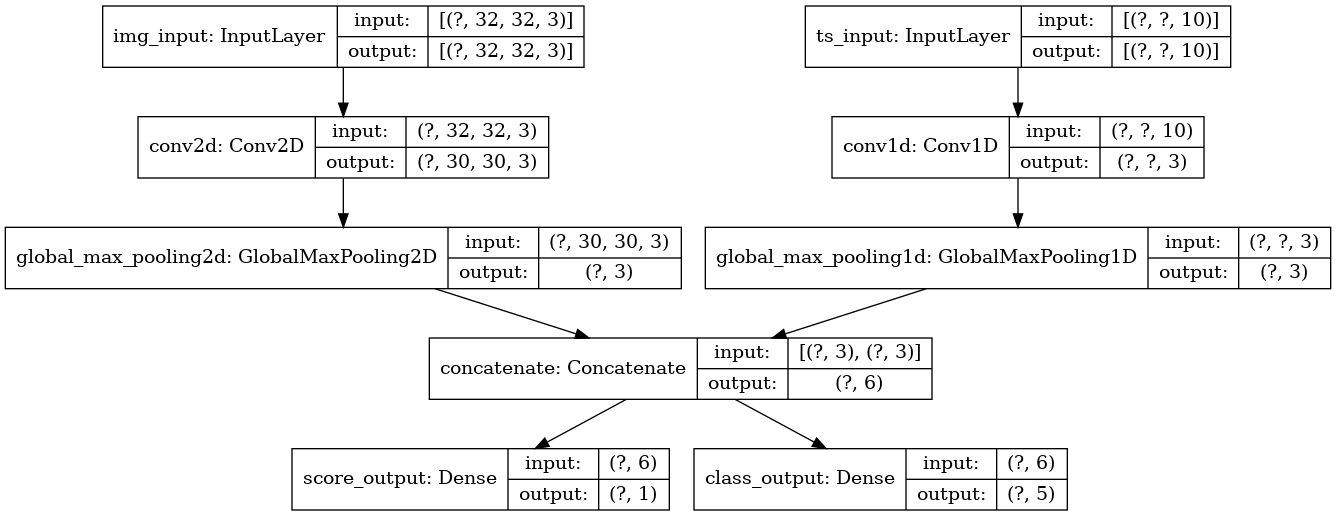

In [32]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

在编译时，通过将损失函数作为列表传递，我们可以为不同的输出指定不同的损失：

In [33]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

如果我们仅将单个损失函数传递给模型，则相同的损失函数将应用于每个输出（此处不合适）。

对于指标同样如此：

In [34]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
        [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        [keras.metrics.CategoricalAccuracy()],
    ],
)

由于我们已为输出层命名，我们还可以通过字典指定每个输出的损失和指标：

In [35]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

如果您的输出超过 2 个，我们建议使用显式名称和字典。

可以使用 `loss_weights` 参数为特定于输出的不同损失赋予不同的权重（例如，在我们的示例中，我们可能希望通过为类损失赋予 2 倍重要性来向“得分”损失赋予特权）：

In [36]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

您还可以选择不为某些输出计算损失，前提是这些输出仅用于预测而不是训练：

In [37]:
# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

在 fit 中将数据传递给多输入或多输出模型的方式与在编译中指定损失函数的方式类似：您可以传递 **NumPy 数组的列表**（以 1:1 映射到接收损失函数的输出）或**将输出名称映射到 NumPy 数组的字典**。

In [38]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

# Generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# Alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)

4/4 [==============================] - 0s 3ms/step - loss: 5.4599 - score_output_loss: 0.8571 - class_output_loss: 4.6028


下面是 `Dataset` 的用例：与我们对 NumPy 数组执行的操作类似，`Dataset` 应返回一个字典元组。

In [39]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

2/2 [==============================] - 2s 1s/step - loss: 5.1390 - score_output_loss: 0.5661 - class_output_loss: 4.5729


## 使用回调

Keras 中的回调是训练期间（某个周期开始时、某个批次结束时、某个周期结束时等）在不同时间点调用的对象，这些对象可用于实现以下行为：

- 在训练期间的不同时间点进行验证（除了内置的按周期验证外）
- 定期或在超过一定准确率阈值时为模型设置检查点
- 当训练似乎停滞不前时，更改模型的学习率
- 当训练似乎停滞不前时，对顶层进行微调
- 在训练结束或超出特定性能阈值时发送电子邮件或即时消息通知
- 等等

回调可以作为列表传递给您对 `fit()` 的调用：

In [40]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/20
625/625 [==============================] - 1s 2ms/step - loss: 0.3733 - sparse_categorical_accuracy: 0.8955 - val_loss: 0.2341 - val_sparse_categorical_accuracy: 0.9301
Epoch 2/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1734 - sparse_categorical_accuracy: 0.9490 - val_loss: 0.1873 - val_sparse_categorical_accuracy: 0.9414
Epoch 3/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.9621 - val_loss: 0.1605 - val_sparse_categorical_accuracy: 0.9526
Epoch 4/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1001 - sparse_categorical_accuracy: 0.9699 - val_loss: 0.1467 - val_sparse_categorical_accuracy: 0.9575
Epoch 5/20
625/625 [==============================] - 1s 2ms/step - loss: 0.0820 - sparse_categorical_accuracy: 0.9751 - val_loss: 0.1528 - val_sparse_categorical_accuracy: 0.9564
Epoch 6/20
625/625 [==============================] - 1s 2ms/step - loss: 0.0692 - sparse_categorica

### 提供多个内置回调

- `ModelCheckpoint`：定期保存模型。
- `EarlyStopping`：当训练不再改善验证指标时，停止训练。
-  `TensorBoard`：定期编写可在 [TensorBoard](https://tensorflow.google.cn/tensorboard) 中可视化的模型日志（更多详细信息，请参阅“可视化”部分）。
- `CSVLogger`：将损失和指标数据流式传输到 CSV 文件。
- 等等

有关完整列表，请参阅[回调文档](https://tensorflow.google.cn/api_docs/python/tf/keras/callbacks/)。

### 编写您自己的回调

您可以通过扩展基类 `keras.callbacks.Callback` 来创建自定义回调。回调可以通过类属性 `self.model` 访问其关联的模型。

确保阅读[编写自定义回调的完整指南](https://tensorflow.google.cn/guide/keras/custom_callback/)。

下面是一个简单的示例，在训练期间保存每个批次的损失值列表：

In [41]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))


## 为模型设置检查点

根据相对较大的数据集训练模型时，经常保存模型的检查点至关重要。

实现此目标的最简单方法是使用 `ModelCheckpoint` 回调：

In [42]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train, y_train, epochs=2, batch_size=64, callbacks=callbacks, validation_split=0.2
)

Epoch 1/2
611/625 [============================>.] - ETA: 0s - loss: 0.3772 - sparse_categorical_accuracy: 0.8946
Epoch 00001: val_loss improved from inf to 0.24281, saving model to mymodel_1
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: mymodel_1/assets
625/625 [==============================] - 1s 2ms/step - loss: 0.3737 - sparse_categorical_accuracy: 0.8956 - val_loss: 0.2428 - val_sparse_categorical_accuracy: 0.9253
Epoch 2/2
605/625 [============================>.] - ETA: 0s - loss: 0.1796 - sparse_categorical_accuracy: 0.9466
Epoch 00002: val_loss improved from 0.24281 to 0.19253, saving model to mymodel_2
INFO:tensorflow:Assets written to: mymodel_2/assets
625/625 [==============================] - 1s 2ms/step - loss: 0.1793 - sparse_categorical_accuracy: 0.94

`ModelCheckpoint` 回调可用于实现容错：在训练随机中断的情况下，从模型的最后保存状态重新开始训练的能力。下面是一个基本示例：

In [43]:
import os

# Prepare a directory to store all the checkpoints.
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

Creating a new model
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2998 - sparse_categorical_accuracy: 0.9132


您还可以编写自己的回调来保存和恢复模型。

有关序列化和保存的完整指南，请参阅[保存和序列化模型](https://tensorflow.google.cn/guide/keras/save_and_serialize/)指南。

## 使用学习率时间表

训练深度学习模型的常见模式是随着训练的进行逐渐减少学习。这通常称为“学习率衰减”。

学习衰减时间表可以是静态的（根据当前周期或当前批次索引提前确定），也可以是动态的（响应模型的当前行为，尤其是验证损失）。

### 将时间表传递给优化器

通过将时间表对象作为优化器中的 `learning_rate` 参数传递，您可以轻松使用静态学习率衰减时间表：

In [44]:
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

提供了几个内置时间表：`ExponentialDecay`、`PiecewiseConstantDecay`、`PolynomialDecay` 和 `InverseTimeDecay`。

### 使用回调实现动态学习率时间表

由于优化器无法访问验证指标，因此无法使用这些时间表对象来实现动态学习率时间表（例如，当验证损失不再改善时降低学习率）。

但是，回调确实可以访问所有指标，包括验证指标！因此，您可以通过使用可修改优化器上的当前学习率的回调来实现此模式。实际上，它甚至以 `ReduceLROnPlateau` 回调的形式内置。

## 可视化训练期间的损失和指标

在训练期间密切关注模型的最佳方法是使用 [TensorBoard](https://tensorflow.google.cn/tensorboard)，这是一个基于浏览器的应用，它可以在本地运行，为您提供：

- 训练和评估的实时损失和指标图
- （可选）层激活直方图的可视化
- （可选）`Embedding` 层学习的嵌入空间的 3D 可视化

如果您已通过 pip 安装了 TensorFlow，则应当能够从命令行启动 TensorBoard：

```
tensorboard --logdir=/full_path_to_your_logs
```

### 使用 TensorBoard 回调

将 TensorBoard 与 Keras 模型和 fit 方法一起使用的最简单方式是 `TensorBoard` 回调。

在最简单的情况下，只需指定您希望回调写入日志的位置即可：

In [45]:
keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

有关更多信息，请参阅 [`TensorBoard` 回调的文档](https://tensorflow.google.cn/api_docs/python/tf/keras/callbacks/tensorboard/)。